In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import datetime
import math
from scipy.ndimage.interpolation import shift
import shapely.wkt
from scipy.stats import pearsonr,spearmanr,kendalltau, linregress
from scipy.optimize import curve_fit 

warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=1.4) 
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines
from os.path import exists

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_log_error, confusion_matrix, classification_report, accuracy_score,explained_variance_score

import json

from helper_functions import build_one_gridcell, calculate_intersection, calculate_grid_cell_corners, make_file_namelist, generate_df
from joblib import Parallel, delayed


/data2/lthapa/miniconda3/envs/ML_py/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Helper Functions

In [2]:
def combine_years(base_file_name, years): # for when all of one year is in a dataframe
    df_all = pd.DataFrame()
    for yr in years:
        filename = base_file_name.replace('YYYY', str(yr))
        df = pd.read_csv(filename)
        df_all = pd.concat([df_all, df], axis=0).reset_index(drop=True)
    return df_all

In [3]:
def combine_per_fire_csv(ids, prefix, str_check): #for when a variable is split by fire, takes a list of irwinids
    df_all = pd.DataFrame()
    for i_d in ids:
        for fname in os.listdir(prefix):
            if fname.startswith(i_d) & (str_check in fname):
                df_fire = pd.read_csv(prefix+fname)
                df_all = pd.concat([df_all, df_fire], axis=0).reset_index(drop=True)
    return df_all

In [4]:
def add_to_features(feats, data_to_add): #feats has the multi index of irwinID, day
    #multiindex = data_to_add.set_index(['irwinID', 'day'])
    feats = pd.merge(feats, data_to_add, how='inner', on=['irwinID', 'day']).drop(columns='Unnamed: 0')
    return feats

In [5]:
def generate_feature_vector(years, is_weighted, features_to_use):
    if 'rave' in features_to_use:
        rave = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_RAVE_Unweighted_12Z_day_start.csv', years)
        print('rave', len(rave))
        features = rave[['irwinID','day']].set_index(['irwinID', 'day'])
        features = add_to_features(features, rave).drop_duplicates()
        
    if 'fre' in features_to_use:
        fre = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_fre/', 'Weighted')
        print('fre', len(fre))
        features = add_to_features(features, fre).drop_duplicates()
        
    if 'hwp' in features_to_use:
        hwp = combine_per_fire_csv(np.unique(rave['irwinID'].values),   
                            './fire_features_hwp/', is_weighted)
        print('hwp', len(hwp))
        features = add_to_features(features, hwp).drop_duplicates()
    
    if 'hrrr_moisture' in features_to_use:
        hrrr_moisture = combine_per_fire_csv(np.unique(rave['irwinID'].values),   
                            './fire_features_hrrr_moisture/', is_weighted)
        print('hrrr_moisture', len(hrrr_moisture))
        features = add_to_features(features, hrrr_moisture).drop_duplicates()
        
    if 'hdw500' in features_to_use:
        hdw500 = combine_per_fire_csv(np.unique(rave['irwinID'].values),   
                            './fire_features_hdw500/', is_weighted)
        print('hdw500', len(hdw500))
        features = add_to_features(features, hdw500).drop_duplicates()

    if 'hdw' in features_to_use:
        hdw = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_HDW_'+is_weighted+'_12Z_day_start.csv', years)
        print('hdw', len(hdw))
        features = add_to_features(features, hdw).drop_duplicates()
        
    if 'resources' in features_to_use:
        """resources = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_resources/', '')"""
        resources = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_resources_split/', '')
        print('resources', len(resources))
        features = add_to_features(features, resources).drop_duplicates()
        
    if 'pft' in features_to_use:
        pft = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_pft/', is_weighted)
        print('pft', len(pft))
        features = add_to_features(features, pft).drop_duplicates()
        
    if 'smops' in features_to_use:
        smops = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_SMOPS_'+is_weighted+'_12Z_day_start.csv', years)
        print('smops', len(smops))
        features = add_to_features(features, smops).drop_duplicates()

    if 'imerg' in features_to_use:
        imerg = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_IMERG_FWI_'+is_weighted+'_12Z_day_start.csv', years)
        print('imerg', len(imerg))
        features = add_to_features(features, imerg).drop_duplicates()

    if 'pws' in features_to_use:
        pws = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_PWS_'+is_weighted+'_12Z_day_start.csv', years)
        print('pws', len(pws))
        features = add_to_features(features, pws).drop_duplicates()
        
    if 'loading' in features_to_use:
        loading = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_LOADING_'+is_weighted+'_12Z_day_start.csv', years)
        print('loading', len(loading))
        features = add_to_features(features, loading).drop_duplicates()
        

    if 'ncar' in features_to_use:
        ncar = combine_per_fire_csv(np.unique(rave['irwinID'].values),   
                            './fire_features_ncar/', is_weighted)
        print('ncar', len(ncar))
        features = add_to_features(features, ncar).drop_duplicates()

    
    if 'esi' in features_to_use:
        esi = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_esi/', is_weighted)
        print('esi', len(esi))
        features = add_to_features(features, esi).drop_duplicates()
        
    if 'chi' in features_to_use:
        chi_2019 = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_CHI_'+is_weighted+'_12Z_day_start.csv', years)
        chi_2020 = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_chi/', is_weighted)
        chi= pd.concat([chi_2019, chi_2020], axis=0).reset_index(drop=True)
        print('chi', len(chi))
        features = add_to_features(features, chi).drop_duplicates()
        
    if 'pop' in features_to_use:
        pop = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_pop/', is_weighted)
        print('pop', len(pop))
        features = add_to_features(features, pop).drop_duplicates()
        
    if 'structures' in features_to_use:
        structures = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_structures/', '')
        print('structures', len(structures))
        features = add_to_features(features, structures).drop_duplicates()
        
    if 'gridmet' in features_to_use:
        gridmet = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_gridmet/',is_weighted)
        gridmet= gridmet.rename({'wind_speed': 'wind_speed_gridmet','mean_vapor_pressure_deficit':'vpd_gridmet'}, axis='columns')
        print('gridmet', len(gridmet))
        features = add_to_features(features, gridmet).drop_duplicates()
        
    if 'slope' in features_to_use:
        slope = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_slope/',is_weighted)
        print('slope', len(slope))
        features = add_to_features(features, slope).drop_duplicates()
        
    if 'elevation' in features_to_use:
        elevation = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_elevation/',is_weighted)
        print('elevation', len(elevation))
        features = add_to_features(features, elevation).drop_duplicates()
        
    if 'heatwave' in features_to_use:
        heatwave = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_heatwave/','')
        print('heatwave', len(heatwave))
        features = add_to_features(features, heatwave).drop_duplicates()
        
    if 'hrrrmet' in features_to_use:
        hrrrmet = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_hrrrmet/',is_weighted)
        hrrrmet= hrrrmet.rename({'wind_speed': 'wind_speed_hrrrmet','vpd_2m':'vpd_hrrrmet'}, axis='columns')
        print('hrrrmet', len(hrrrmet))
        features = add_to_features(features, hrrrmet).drop_duplicates()
        
    return features


In [6]:
def summarize_error(df, truth_name, method_name, train_vars):
    r2 =r2_score(df[truth_name], df[method_name])
    rmse =RMSE(df[truth_name], df[method_name])
    mad =MAD(df[truth_name], df[method_name])
    
    n = len(df[truth_name].values)
    k = len(train_vars)
    
    adjusted_r2 = 1-(((1-r2)*(n-1))/(n-k-1))
    
    return(r2,adjusted_r2, rmse, mad)

In [7]:
def shift_ndays(df_to_shift,ndays,name_col_to_shift, name_shifted_col, time_col):
    df_shifted = resample_daily(df_to_shift, time_col)
    for ii in range(len(name_shifted_col)):
        df_shifted[name_shifted_col[ii]] = df_shifted[name_col_to_shift[ii]].shift(ndays)
    return df_shifted

In [8]:
def resample_daily(df_nondaily, time_name):
    df_nondaily['datetime'] = pd.to_datetime(df_nondaily[time_name])
    df_nondaily = df_nondaily.set_index(['datetime'])
    df_daily = df_nondaily.resample('D').asfreq()
    df_daily = df_daily.reset_index()
    return df_daily

In [9]:
def get_dfeatures(df, names, suf_now, suf_back): #to today/yesterday, flip it later
    for name in names:
        df['d'+name+suf_now] = df[name+suf_now]/df[name+suf_back]
    return df

## load in the training set from paper 2

In [ ]:
#LOAD IN THE FEATURE CSV WITH HDW500 (which now also has HRRR moisture added in)
training = pd.read_csv('features_no_outliers_weightedHDW500.csv',
                                           parse_dates=['datetime'])
training=training.drop(columns=['Unnamed: 0'])

training = training[(training['datetime']>=np.datetime64('2021-01-01'))|(training['datetime']<=np.datetime64('2019-12-31'))]
training

In [ ]:
print(training.columns.values)

In [ ]:
feature_subsets = {}
feature_subsets['features_hrrrmet_hwp'] = ['vpd_hrrrmet', 'dvpd_hrrrmet',
                                    'wind_speed_hrrrmet','dwind_speed_hrrrmet',
                                      'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'soilm_30cm',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72','air_quantity',
                                   'FRE_1' ]

In [ ]:
# RANDOM FOREST METHOD
# we shouldn't have to drop nans for the RF, as long as we run it AFTER the scaled method cells

thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 1.5


feature_set_names = ['features_hrrrmet_hwp']


df_error_metrics_rf = pd.DataFrame(index=feature_set_names, 
                                columns=['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD',
                                         'log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD',
                                        'SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD',
                                        'log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD',

                                        'decrease_precision', 'decrease_recall', 
                                         'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])
#train the random forest
for ii in range(len(feature_set_names)):
    training_variables = feature_subsets[feature_set_names[ii]]

    gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=5)
    #gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=10) 
    gsearch.fit(training.loc[:, training_variables], training.loc[:, ['Log_Scaling_Factor']])

    print(feature_set_names[ii] + ' OOB R2 score is: '+ str(gsearch.oob_score_))
    #

# Combine the mtbs polygons for 2020, fill them into the 2020 polygons

In [11]:
#load in the 2020 fires
fires_2020 = gpd.read_file('./fire_polygons/ClippedFires2020_VIIRS_daily_12Z_Day_Start.geojson')
print(fires_2020)

       Local Day                               irwinID  Incident Number  \
0     2020-07-01  3215B87E-97CC-4F60-A276-DE4120F4AB5B       11751212.0   
1     2020-07-01  3DE641EE-702E-4EF7-B274-F1B5F12A0506       11749823.0   
2     2020-07-02  3215B87E-97CC-4F60-A276-DE4120F4AB5B       11751212.0   
3     2020-07-02  44F1AEC6-36D9-410E-8A11-4EF5FD7FA781       11759379.0   
4     2020-07-03  2AD7C3F8-5CB0-480C-BCB1-2EC9FF77619D       11751160.0   
...          ...                                   ...              ...   
2711  2020-12-12  1FDE9A25-8AB5-4606-8F61-93EBFA5E7FF0       11980186.0   
2712  2020-12-18  33CBB9DC-6983-4F47-B821-9C9A6CAC381D       11908866.0   
2713  2020-12-23  3883D723-E328-4DA2-A7E8-ECBD419B420A       11980587.0   
2714  2020-12-24  3883D723-E328-4DA2-A7E8-ECBD419B420A       11980587.0   
2715  2020-12-25  3883D723-E328-4DA2-A7E8-ECBD419B420A       11980587.0   

         Fire Name Current Day  Current Overpass   Lat Fire    Lon Fire  \
0        HOWE PEAK  2020

In [12]:
#get the fires for 2020
fires_sept_2020 = fires_2020[(fires_2020['Local Day']>='2020-09-01')&
                             (fires_2020['Local Day']<='2020-09-30')]

In [ ]:
file_list = os.listdir('../mtbs/2020/')

mtbs_bdrys = gpd.GeoDataFrame()
for file in file_list:
    if file.endswith('_burn_bndy.shp'):
        gdf_file = gpd.read_file('../mtbs/2020/'+file)
        mtbs_bdrys = pd.concat([mtbs_bdrys, gdf_file], axis=0)

mtbs_bdrys_merged = mtbs_bdrys.dissolve(by='irwinID').reset_index()
#print(mtbs_bdrys_merged) #all the final perimeters for 2020 with irwinids
mtbs_bdrys_merged.to_file('2020_mtbs_perimeters.geojson')

In [38]:
mtbs_bdrys_merged = gpd.read_file('2020_mtbs_perimeters.geojson').to_crs('epsg:3347')
print(mtbs_bdrys_merged.crs)
print(fires_sept_2020.crs)

epsg:3347
epsg:3347


In [39]:
print(len(np.unique(fires_sept_2020['irwinID'].values)))
filled_fires_sept_2020 = gpd.GeoDataFrame()
for irwin in np.unique(fires_sept_2020['irwinID'].values):
    print(irwin)
    single_incident_daily = resample_daily(fires_sept_2020[fires_sept_2020['irwinID']==irwin], 'Local Day')
    missing_geom_loc = np.where(single_incident_daily['geometry'].isna())[0]
    for location in missing_geom_loc:
        single_incident_daily.loc[location, 'geometry']=mtbs_bdrys_merged['geometry'][mtbs_bdrys_merged['irwinID']==irwin].values
    
    #ffill the nans in the irwinid column
    single_incident_daily['irwinID'] = single_incident_daily['irwinID'].fillna(method='ffill')    
    
    filled_fires_sept_2020 = pd.concat([filled_fires_sept_2020, single_incident_daily], axis=0)

#replace Local Day with what's in datetime
print(filled_fires_sept_2020)


#filled_fires_sept_2020.to_file('Sept_2020_Fire_Polys_with_NaNs.geojson',driver='GeoJSON')
filled_fires_sept_2020.to_file('Sept_2020_Fire_Polys_with_Full_Perim.geojson',driver='GeoJSON')

102
00B3EDB2-87A4-4D0A-A834-4E1012BF9693
07A2F787-CF35-46AB-92FB-EEA413392BE3
09509DA4-590D-43E2-A28B-035FC42DC19F
0A2BB376-060F-4A68-959A-25B146A7C1BD
0AFEBC32-36EE-4FA8-AEC5-419C9C6BA51D
0BFD6964-3A26-4821-8FBA-5D7235ACA4B3
0DF1645C-5A67-4734-89A6-172330D04945
15E4D9B8-DF91-45CE-AE58-26962AEAF743
16DC7F93-8C52-4CCC-8256-B2FE9F18DF75
1AA854A7-3969-4969-9413-950CF0C2DFB6
1E4A0681-76DE-459B-B08A-EE73C0E6642B
22EE3313-37C1-435F-B2F0-1A5DA3DF4F2B
24CDAB5C-7832-4546-BD05-15CC702A0326
25C97DD7-440E-4291-B119-EFA3B7E93859
2826E416-7DF4-4E5E-8516-00694E48D4E7
2BF5EC75-EC94-42C1-B7DE-9D2CE3242747
2D317440-5A5C-43E2-82E4-E89AE2B922DF
336B79CA-5BEF-4201-8DC4-7F0B9E5B7CBF
33CBB9DC-6983-4F47-B821-9C9A6CAC381D
37B62542-EA3C-497E-80D1-34816DE96D65
3F63C271-1D4D-4E24-B9FF-97028046BD1D
3F9BBD22-DEC9-428D-B8F4-10327F986FAB
4310F979-D5B9-443D-9E1D-E4C67A446EA5
43EA7456-8566-432E-B722-D3B2D62B989F
441FD48B-515B-49E8-984C-515EA5D0CD49
4A3F60A6-9E35-4D5E-8317-042F2DB93B2E
4A4C88E1-1FBD-4785-A634-9F8E722E71

# Get RAVE and polygons based on RAVE

In [10]:
path_poly = '/data2/lthapa/ML_daily/'
suffix_poly = 'Z_Day_Start.geojson'
start_time=12


print(path_poly+'Sept_2020_Fire_Polys_with_Full_Perim.geojson')
    
fire_daily = gpd.read_file(path_poly+'Sept_2020_Fire_Polys_with_Full_Perim.geojson')
print(fire_daily.crs)
    
fire_daily=fire_daily.drop(columns=['Current Overpass'])
fire_daily = fire_daily.drop(np.where(fire_daily['geometry']==None)[0])
fire_daily['fire area (ha)'] = fire_daily['geometry'].area/10000 #hectares. from m2
fire_daily.set_geometry(col='geometry', inplace=True) #designate the geometry column
fire_daily = fire_daily.rename(columns={'Current Day':'UTC Day', 'datetime': str(start_time)+ 'Z Start Day'})
print(fire_daily)

/data2/lthapa/ML_daily/Sept_2020_Fire_Polys_with_Full_Perim.geojson
epsg:3347
            12Z Start Day   Local Day                               irwinID  \
0     2020-09-07T00:00:00  2020-09-07  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   
1     2020-09-08T00:00:00  2020-09-08  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   
2     2020-09-09T00:00:00  2020-09-09  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   
3     2020-09-10T00:00:00  2020-09-10  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   
4     2020-09-11T00:00:00  2020-09-11  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   
...                   ...         ...                                   ...   
1294  2020-09-05T00:00:00  2020-09-05  FEF1C45E-C557-4934-87CC-06B12392FFFA   
1295  2020-09-06T00:00:00  2020-09-06  FEF1C45E-C557-4934-87CC-06B12392FFFA   
1296  2020-09-16T00:00:00  2020-09-16  FFCB89F5-98FB-4C3A-9554-3D1554181A63   
1297  2020-09-17T00:00:00  2020-09-17  FFCB89F5-98FB-4C3A-9554-3D1554181A63   
1298  2020-09-18T00:00:00  2020-09-18  FFCB89F5-98FB-

In [34]:
def calculate_intersection(poly,dataset_name,bf):
    #load in the merra grid

    grid = xr.open_dataset(dataset_name+'.nc')

    

    #get the bounds of the buffered polygons

    #poly_latlon =poly#.to_crs(epsg=4326)

    #bounds = poly_latlon.buffer(bf).bounds

    bounds = poly.buffer(bf).to_crs(epsg=4326).bounds
    print(bounds)



    #first check for rows and cols, filtering near the polygon

    [rows,cols] = np.where((grid.LAT_CTR.values>bounds['miny'].values)&

                    (grid.LAT_CTR.values<bounds['maxy'].values)&

                    (grid.LON_CTR.values>bounds['minx'].values)&

                    (grid.LON_CTR.values<bounds['maxx'].values))

    locs = zip(rows,cols)





    #make a geodataframe (in paralell of the rows and cols)

    results = Parallel(n_jobs=8)(delayed(build_one_gridcell)

                                 (grid['LAT_COR'].values, grid['LON_COR'].values,

                                  grid['LAT_CTR'].values, grid['LON_CTR'].values,loc) 

                                 for loc in locs)



    #format the grid subset into a dataframs

    df_grid=gpd.GeoDataFrame(results)

    df_grid.columns = ['lat', 'lon', 'row', 'col', 'geometry']

    df_grid.set_geometry(col='geometry',inplace=True,crs='EPSG:4326') #need to say it's in lat/lon before transform to LCC

    df_grid=df_grid.to_crs(epsg=3347)



    #intersect the polygon with the grid subset

    intersection = gpd.overlay(df_grid, poly, how='intersection',keep_geom_type=False).drop_duplicates()

    intersection['grid intersection area (ha)'] =intersection['geometry'].area/10000

    intersection['weights'] = intersection['grid intersection area (ha)']/intersection['fire area (ha)'] 

    

    return intersection

In [19]:
rave_grid = xr.open_dataset('RAVE_GRID_3KM.nc')

irwinIDs = np.unique(fire_daily['irwinID'].values)
print('We are processing ' +str(len(irwinIDs)) + ' unique fires for Sept 2020')

filled_fires_sept_2020 = gpd.GeoDataFrame()

rave_all = pd.DataFrame()
for ii in range(len(irwinIDs)):
    print(ii)
    fireID=irwinIDs[ii]
    print(fireID)
    df_inci = fire_daily[fire_daily['irwinID']==fireID] #this is what gets fed to the feature selection code
    single_incident_daily = resample_daily(fires_sept_2020[fires_sept_2020['irwinID']==fireID], 'Local Day')
    single_incident_daily['geometry'] = single_incident_daily['geometry'].fillna()
    #print(single_incident_daily)
    #from the rave_timeseries function
    varis = ['day','FRE']#, 'FRP_SD', 'FRE']#, 'CO2', 'CO', 'SO2', 'OC','BC', 'PM25', 'NOx', 'NH3','TPM', 'VOCs', 'CH4'] #don't need 'area', it's the area of each cell
    df_rave = generate_df(varis, len(df_inci))

    #do the intersection, in parallel
    rave_intersections = Parallel(n_jobs=8)(delayed(calculate_intersection)
                                 (df_inci.iloc[kk:kk+1],'RAVE_GRID_3KM',3000) 
                                 for kk in range(len(df_inci)))
    #print(calculate_intersection(df_inci.iloc[11:12],'RAVE_GRID_3KM',3000))
    print([rave_intersections[jj]['weights'].sum() for jj in range(len(rave_intersections))])

    fire_rave_intersection=gpd.GeoDataFrame(pd.concat(rave_intersections, ignore_index=True))
    fire_rave_intersection.set_geometry(col='geometry')  
    

    #print(fire_rave_intersection)
    fire_rave_intersection = fire_rave_intersection.set_index([str(start_time)+ 'Z Start Day', 'row', 'col'])
    fire_rave_intersection=fire_rave_intersection[~fire_rave_intersection.index.duplicated()]

    fire_rave_intersection_xr = fire_rave_intersection.to_xarray()
    fire_rave_intersection_xr['weights_mask'] = xr.where(fire_rave_intersection_xr['weights']>0,1, np.nan)
    
    
    times = pd.date_range(np.datetime64(df_inci[str(start_time)+ 'Z Start Day'].iloc[0]),
                        np.datetime64(df_inci[str(start_time)+ 'Z Start Day'].iloc[len(df_inci)-1])+
                        np.timedelta64(1,'D'))
    rave_filenames,times_back_used = make_file_namelist(times,
                                                        '/data2/lthapa/YYYY/RAVE/MM/RAVE-HrlyEmiss-3km-CONUS_v1r1_blend_sYYYYMMDD.nc')                                                 
    
    #print(rave_filenames)
    dat_rave = xr.open_mfdataset(rave_filenames,concat_dim='time',combine='nested',compat='override', coords='all')

    dat_rave = dat_rave.resample(time=str(24)+'H',base=start_time).sum(dim='time') #take the daily sum
    
    #select the locations and times we want
    dat_rave_sub = dat_rave.isel(grid_yt = fire_rave_intersection_xr['row'].values.astype(int), 
                    grid_xt = fire_rave_intersection_xr['col'].values.astype(int)).sel(
                    time = pd.to_datetime(fire_rave_intersection_xr[str(start_time)+ 'Z Start Day'].values+
                                         'T12:00:00.000000000'))#these should be lined up correctly
    #print(dat_rave_sub)
    #plug in the rave grid polygons
    missing_geom_loc = np.where(single_incident_daily['geometry'].is_empty)[0]
    for location in missing_geom_loc:
        missing_date = np.datetime64(single_incident_daily.loc[location,'datetime'])
        missing_date_points = dat_rave_sub.sel(time=missing_date+np.timedelta64(12,'h'))
        print(missing_date)
        row_have_fre, col_have_fre = np.where(missing_date_points['FRE'].values!=0)
        print(missing_date_points['grid_yt'].values[row_have_fre])
        """
        #persist the most recent value if there aren't any RAVE points
        if len(missing_date_points['grid_yt'].values[row_have_fre])==0 or len(missing_date_points['grid_xt'].values[col_have_fre])==0:
            continue
        
        locs = zip(missing_date_points['grid_yt'].values[row_have_fre],
                   missing_date_points['grid_xt'].values[col_have_fre])
        poly_grid_cells = gpd.GeoDataFrame(Parallel(n_jobs=8)(delayed(build_one_gridcell)
                                 (rave_grid['LAT_COR'].values, rave_grid['LON_COR'].values,
                                  rave_grid['LAT_CTR'].values, rave_grid['LON_CTR'].values,loc) 
                                 for loc in locs))
        poly_grid_cells.columns = ['lat', 'lon', 'row', 'col', 'geometry']
        poly_grid_cells['irwinID'] = fireID
        
        poly_grid_cells_irwin = poly_grid_cells[['irwinID','geometry']].dissolve().set_crs('epsg:4326')
        single_incident_daily.loc[location, 'geometry']=poly_grid_cells_irwin['geometry'].to_crs('epsg:3347').values[0]
        
    filled_fires_sept_2020 = pd.concat([filled_fires_sept_2020, single_incident_daily], axis=0)
    
    ndays = len(fire_rave_intersection_xr[str(start_time)+ 'Z Start Day'])

    df_rave['day'].iloc[:] = pd.to_datetime(fire_rave_intersection_xr[str(start_time)+ 'Z Start Day'].values)
   
    df_rave['FRE'] = np.nansum(fire_rave_intersection_xr['weights'].values*dat_rave_sub['FRE'].values, axis=(1,2))
    
    print(df_rave)
    #STILL NEED TO SAVE DF_RAVE
    
    #df_rave.to_csv('./fire_features_2020/fire_features_fre/'+fireID+'2020_Daily_FRE_Weighted_'+str(start_time)+'Z_day_start.csv') #daily averages


    
print(filled_fires_sept_2020)
#filled_fires_sept_2020.to_file('Sept_2020_Fire_Polys_with_RAVE_Polys.geojson',driver='GeoJSON')    
    """
    
    
    

We are processing 102 unique fires for Sept 2020
0
00B3EDB2-87A4-4D0A-A834-4E1012BF9693
[0.9999999999999997, 1.0000000000000007, 1.0000000000000007, 0.9999999999999997, 0.9999999999999994, 0.9999999999999996, 1.0, 1.0, 1.0000000000000007, 0.9999999999999983, 1.0000000000000133, 0.9999999999999988, 1.0, 0.9999999999999999]
2020-09-18T00:00:00.000000
[]
1
07A2F787-CF35-46AB-92FB-EEA413392BE3
[1.0000000000000002, 0.9999999999999992, 0.9999999999999956, 0.9999999999999981, 1.0000000000000013, 1.0000000000000084, 1.0000000000000044, 0.9999999999999999, 0.9999999999999993, 1.0000000000000038, 0.9999999999999947, 0.9999999999999947, 1.0000000000000024, 0.9999999999999999, 0.999999999999995, 0.9999999999999982, 1.0000000000000004, 1.0000000000000004, 1.0000000000000004, 1.0000000000000004, 1.0000000000000004, 1.0]
2020-09-18T00:00:00.000000
[290. 290. 291. 291. 291. 292. 292. 292. 292. 292. 293. 293. 293.]
2020-09-19T00:00:00.000000
[]
2020-09-20T00:00:00.000000
[]
2020-09-21T00:00:00.000000
[

KeyboardInterrupt: 

In [217]:
print(location)
print(single_incident_daily.loc[location, 'geometry'].is_empty)
print(single_incident_daily.loc[location-1, 'geometry'].is_empty)

#print(len(single_incident_daily.loc[location-1, 'geometry']))

single_incident_daily.loc[location, 'geometry'] = gpd.GeoSeries(single_incident_daily.loc[location-1, 'geometry'])

11
True
False


ValueError: Incompatible indexer with Series

In [178]:
filled_fires_sept_2020['geometry'] = filled_fires_sept_2020['geometry'].fillna()
filled_fires_sept_2020

,datetime,Local Day,irwinID,Incident Number,Fire Name,Current Day,Current Overpass,Lat Fire,Lon Fire,Number of NEW VIIRS points,NEW FRP,daily_area,geometry
0,2020-09-07,2020-09-07,00B3EDB2-87A4-4D0A-A834-4E1012BF9693,11943503.0,BIG HOLLOW,2020-09-08,1042.0,45.92707,-121.9799,12.0,268.54,211.574663,"MULTIPOLYGON (((3919568.378 1635426.400, 39195..."
1,2020-09-08,2020-09-08,00B3EDB2-87A4-4D0A-A834-4E1012BF9693,11943503.0,BIG HOLLOW,2020-09-09,2206.0,45.92707,-121.9799,296.0,3257.75,2475.259442,"MULTIPOLYGON (((3920185.284 1634911.471, 39201..."
2,2020-09-09,2020-09-09,00B3EDB2-87A4-4D0A-A834-4E1012BF9693,11943503.0,BIG HOLLOW,2020-09-10,2148.0,45.92707,-121.9799,272.0,2334.30,1885.054054,"MULTIPOLYGON (((3920000.230 1633013.462, 39199..."
3,2020-09-10,2020-09-10,00B3EDB2-87A4-4D0A-A834-4E1012BF9693,11943503.0,BIG HOLLOW,2020-09-11,2130.0,45.92707,-121.9799,89.0,835.20,736.680530,"MULTIPOLYGON (((3920648.358 1633085.585, 39206..."
4,2020-09-11,2020-09-11,00B3EDB2-87A4-4D0A-A834-4E1012BF9693,11943503.0,BIG HOLLOW,2020-09-12,2200.0,45.92707,-121.9799,76.0,214.17,406.680814,"MULTIPOLYGON (((3911383.050 1643153.142, 39113..."
5,2020-09-12,2020-09-12,00B3EDB2-87A4-4D0A-A834-4E1012BF9693,11943503.0,BIG HOLLOW,2020-09-13,2142.0,45.92707,-121.9799,41.0,303.68,167.081336,"MULTIPOLYGON (((3919980.922 1632657.416, 39199..."
6,2020-09-13,2020-09-13,00B3EDB2-87A4-4D0A-A834-4E1012BF9693,11943503.0,BIG HOLLOW,2020-09-13,2030.0,45.92707,-121.9799,4.0,24.75,31.968238,"MULTIPOLYGON (((3919065.991 1632169.666, 39190..."
7,2020-09-14,2020-09-14,00B3EDB2-87A4-4D0A-A834-4E1012BF9693,11943503.0,BIG HOLLOW,2020-09-15,2106.0,45.92707,-121.9799,48.0,389.40,584.760256,"MULTIPOLYGON (((3919351.413 1632338.820, 39193..."
8,2020-09-15,2020-09-15,00B3EDB2-87A4-4D0A-A834-4E1012BF9693,11943503.0,BIG HOLLOW,2020-09-16,2042.0,45.92707,-121.9799,42.0,106.30,525.254140,"MULTIPOLYGON (((3918938.379 1631855.951, 39189..."
9,2020-09-16,2020-09-16,00B3EDB2-87A4-4D0A-A834-4E1012BF9693,11943503.0,BIG HOLLOW,2020-09-17,2118.0,45.92707,-121.9799,41.0,58.60,224.857505,"MULTIPOLYGON (((3919346.754 1631873.918, 39193..."


In [185]:
# Create a sample GeoPandas DataFrame
data = {'name': ['A', 'B', 'C', 'D'],
        'geometry': [Point(1, 1), None, None, None ]}
gdf = gpd.GeoDataFrame(data, geometry='geometry')

# Forward fill the 'geometry' column
gdf['geometry'] = gdf['geometry'].fillna(method='ffill')

# Display the updated GeoPandas DataFrame
print(gdf)

ValueError: Cannot specify both 'value' and 'method'.

In [113]:
diss = poly_grid_cells_irwin.dissolve()

<AxesSubplot:>

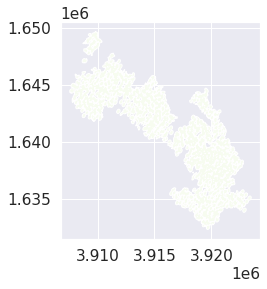

In [149]:
filled_fires_sept_2020['datetime'] = str(filled_fires_sept_2020['datetime'])
filled_fires_sept_2020[0:5].plot(column = 'datetime', cmap='GnBu')


<AxesSubplot:>

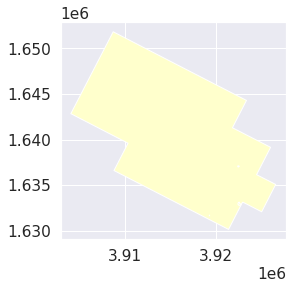

In [147]:
filled_fires_sept_2020.plot(column = 'datetime', cmap='YlOrRd')


In [68]:
missing_geom_loc = np.where(single_incident_daily['geometry'].isna())[0]
for location in missing_geom_loc:
    print(single_incident_daily.loc[location,'datetime'])
    print(fire_rave_intersection[['rows','cols']][fire_rave_intersection['12Z Start Day']==single_incident_daily.loc[location,'datetime']])


2020-09-18 00:00:00


KeyError: "None of [Index(['rows', 'cols'], dtype='object')] are in the [columns]"

# Try making the training vector separately from the testing one

In [ ]:
#WITH 500M DEFINITION OF HDW and hrrr forecasted moiosture
"""training = generate_feature_vector([2019,2021], 'Weighted', ['rave', 'fre','hwp', 'hdw500', #'imerg', 'gridmet','hrrrmet',
                                                                  'heatwave',''
                                                                  'pft', 'chi',
                                                                  'smops','ncar','hrrr_moisture',
                                                                  'pws','esi',
                                                                  'loading',
                                                                  'slope','elevation',
                                                                  'resources','pop','structures'])
print('With one day fires: ', len(np.unique(training['irwinID'])), len(training))"""

testing = generate_feature_vector([2020], 'Weighted', ['rave', 'fre','hwp', 'hdw500', 'imerg', 'gridmet','hrrrmet',
                                                                  'heatwave',''
                                                                  'pft', 'chi',
                                                                  'smops','ncar','hrrr_moisture',
                                                                  'pws','esi',
                                                                  'loading',
                                                                  'slope','elevation',
                                                                  'resources','pop','structures'])
print('With one day fires: ', len(np.unique(testing['irwinID'])), len(testing))

In [ ]:
# drop fires that last one day
features_ge_2 = testing[testing.groupby('irwinID')['day'].transform('size').ge(2)].reset_index(drop=True)
print('Dropping one day fires: ', len(np.unique(features_ge_2['irwinID'])), len(features_ge_2))

features_ge_3 = testing[testing.groupby('irwinID')['day'].transform('size').ge(3)].reset_index(drop=True)
print('Dropping one and two day fires: ', len(np.unique(features_ge_3['irwinID'])), len(features_ge_3))

features_ge = features_ge_3.drop(columns=['hwp_1'])#.rename(columns={'hwp_1':'hwp_1_poly'}) #get rid of the new HWP_1 (same poly, prev day)

In [ ]:
#shift the features
events = np.unique(features_ge['irwinID']) #all the incidents

features_to_shift = ['FRE',
                     'vpd_hrrrmet', 'wind_speed_hrrrmet',#raw weather
                     'hwp', 
                     'PFT',
                     'soilm_30cm',
                     'air_quantity', 
                     'structures_threatened_72']#features_ge.columns.values[2:]
features_shifted_1 = [] #one day shifts
features_shifted_2 = [] #two day shifts

print(features_to_shift)

for ii in range(len(features_to_shift)):
    features_shifted_1.append(features_to_shift[ii]+'_1')
    features_shifted_2.append(features_to_shift[ii]+'_2')

features_with_shifts_weighted = pd.DataFrame()

for jj in range(len(events)):
    df_fire = features_ge[features_ge['irwinID']==events[jj]].drop_duplicates(subset='day') #removes duplicate rows
    df_fire_shifted_1 = shift_ndays(df_fire, -1, features_to_shift, features_shifted_1, 'day')
    df_fire_shifted_2 = shift_ndays(df_fire, -2, features_to_shift, features_shifted_2, 'day')
    
    
    df_fire_concat = pd.concat([df_fire_shifted_1,
                                df_fire_shifted_2[features_shifted_2]], axis=1)    
    
    features_with_shifts_weighted = pd.concat([features_with_shifts_weighted, 
                                               df_fire_concat], axis=0).reset_index(drop=True)
    
# filter to september
september_testing = features_with_shifts_weighted[
    (features_with_shifts_weighted['datetime']>=np.datetime64('2020-09-01'))&
    (features_with_shifts_weighted['datetime']<=np.datetime64('2020-09-30'))]

print(september_testing[september_testing['irwinID']=='EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA'][['datetime','FRE','FRE_1', 'FRE_2']])    

#get the scaling factor, USING FRE
september_testing['Scaling_Factor'] = september_testing['FRE_1']/september_testing['FRE']

#get the log of the scaling factor
september_testing['Log_Scaling_Factor']= np.log10(september_testing['Scaling_Factor'])

#replace infs with nans, dropping days that were added for the shift as well as days where the scaling factor may have gone to inf
september_testing.replace([np.inf, -np.inf], np.nan, inplace=True)
#drop nans (get rid of this for testing the 19/20 WF/DIXIE case)
september_testing.dropna(axis=0,how='any').reset_index(drop=True)
print(len(september_testing))

"""#get the outliers
features_with_shifts_weighted = find_outliers(features_with_shifts_weighted, 'Log_Scaling_Factor')
print(len(features_with_shifts_weighted[features_with_shifts_weighted['Log_Scaling_Factor_is_outlier']==False]))
print(features_with_shifts_weighted.head()) #this is ordered by the irwinID, so 2019 and 2020 will be somewhat jumbled"""

In [ ]:
#check for nans, have to decide what to do with those!
#september_testing[september_testing.isna().any(axis=1)][['datetime', 'irwinID','FRE', 'FRE_1', 'FRE_2']]
#september_testing[september_testing.isna().any(axis=1)][['datetime', 'irwinID','hwp', 'hwp_1', 'hwp_2']]
september_testing[september_testing.isna().any(axis=1)].iloc[1]

#print(september_testing[september_testing['irwinID']=='00B3EDB2-87A4-4D0A-A834-4E1012BF9693'][['datetime','FRE','FRE_1', 'FRE_2']])    
print(september_testing[september_testing['irwinID']=='EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA'][['datetime','FRE','FRE_1', 'FRE_2', 'hwp']])    

print(september_testing[september_testing['irwinID']=='EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA'][['hwp_1']].values/
     september_testing[september_testing['irwinID']=='EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA'][['hwp']].values)    


In [ ]:
features_relative = get_dfeatures(september_testing,
                                  [
                     'vpd_hrrrmet', 'wind_speed_hrrrmet',
                     'hwp',
                     'PFT', ], 
                                '_1', '') #to today/yesterday, flip it later

features_relative = get_dfeatures(features_relative,
                                  [
                     'vpd_hrrrmet', 'wind_speed_hrrrmet',
                     'hwp',
                     'PFT', ], 
                                '_2', '_1') #to today/yesterday, flip it later
features_relative

In [ ]:
features_relative[features_relative.isna().any(axis=1)]


In [ ]:
# test the sensitivity to weighted and unweighted
testing_unweighted = generate_feature_vector([2020], 'Unweighted', ['rave', 'fre','hwp', 'hdw500','imerg','gridmet','hrrrmet',
                                                       'heatwave',
                                                                  'pft', 'hrrr_moisture',
                                                                  'pws',
                                                       'ncar', 'smops',
                                                                  'loading',
                                                                  'elevation',
                                                                  'resources','pop','structures'])

testing_weighted = generate_feature_vector([2020], 'Weighted', ['rave', 'fre','hwp', 'hdw500','imerg','gridmet','hrrrmet',
                                                       'heatwave',
                                                                  'pft', 'hrrr_moisture',
                                                                  'pws',
                                                       'ncar', 'smops',
                                                                  'loading',
                                                                  'elevation',
                                                                  'resources','pop','structures'])
#print('With one day fires: ', len(np.unique(testing['irwinID'])), len(testing))


august_unweighted = testing_unweighted[testing_unweighted['irwinID']=='EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA']
fig, ax = plt.subplots(figsize=(20, 7))
ax2=ax.twinx()
#fire_plot.plot(y=features_plot_timeseries[name], alpha=1, ax=ax)
august_unweighted.plot(y=['hwp','vpd_hrrrmet','wind_speed_hrrrmet'], 
               label=['hourly wildfire potential', 'vpd_hrrrmet','wind_speed_hrrrmet'],alpha=1, ax=ax2)
august_unweighted.plot(y=['FRE'],style=['k-'],linewidth=3, ax=ax)
#ax.set_yscale('log')
ax.legend(loc='upper left', fontsize=24)
#ax2.set_yscale('log')
ax2.legend(loc='upper center', fontsize=24)
ax2.grid(False)

plt.title('August', fontsize=32)
plt.show()

fig, ax = plt.subplots(figsize=(20, 7))
ax2=ax.twinx()
#fire_plot.plot(y=features_plot_timeseries[name], alpha=1, ax=ax)
august_unweighted.plot(y=['PFT','soilm_30cm'], 
               label=['PFT', 'soilm_30cm',],alpha=1, ax=ax2)
august_unweighted.plot(y=['FRE'],style=['k-'],linewidth=3, ax=ax)
#ax.set_yscale('log')
ax.legend(loc='upper left', fontsize=24)
#ax2.set_yscale('log')
ax2.legend(loc='upper center', fontsize=24)
ax2.grid(False)

plt.title('August', fontsize=32)
plt.show()


fig, ax = plt.subplots(figsize=(20, 7))
ax2=ax.twinx()
#fire_plot.plot(y=features_plot_timeseries[name], alpha=1, ax=ax)
august_unweighted.plot(y=['soilm_30cm'], 
               label=['soilm_30cm',],alpha=1, ax=ax2)
august_unweighted.plot(y=['FRE'],style=['k-'],linewidth=3, ax=ax)
#ax.set_yscale('log')
ax.legend(loc='upper left', fontsize=24)
#ax2.set_yscale('log')
ax2.legend(loc='upper center', fontsize=24)
ax2.grid(False)

plt.title('August', fontsize=32)
plt.show()


august_weighted = testing_weighted[testing_weighted['irwinID']=='EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA']
fig, ax = plt.subplots(figsize=(20, 7))
ax2=ax.twinx()
#fire_plot.plot(y=features_plot_timeseries[name], alpha=1, ax=ax)
august_weighted.plot(y=['hwp','vpd_hrrrmet','wind_speed_hrrrmet'], 
               label=['hourly wildfire potential', 'vpd_hrrrmet','wind_speed_hrrrmet'],alpha=1, ax=ax2)
august_weighted.plot(y=['FRE'],style=['k-'],linewidth=3, ax=ax)
#ax.set_yscale('log')
ax.legend(loc='upper left', fontsize=24)
#ax2.set_yscale('log')
ax2.legend(loc='upper center', fontsize=24)
ax2.grid(False)

plt.title('August', fontsize=32)
plt.show()


fig, ax = plt.subplots(figsize=(20, 7))
ax2=ax.twinx()
#fire_plot.plot(y=features_plot_timeseries[name], alpha=1, ax=ax)
august_weighted.plot(y=['PFT','soilm_30cm'], 
               label=['PFT', 'soilm_30cm',],alpha=1, ax=ax2)
august_weighted.plot(y=['FRE'],style=['k-'],linewidth=3, ax=ax)
#ax.set_yscale('log')
ax.legend(loc='upper left', fontsize=24)
#ax2.set_yscale('log')
ax2.legend(loc='upper center', fontsize=24)
ax2.grid(False)

plt.title('August', fontsize=32)
plt.show()

fig, ax = plt.subplots(figsize=(20, 7))
ax2=ax.twinx()
#fire_plot.plot(y=features_plot_timeseries[name], alpha=1, ax=ax)
august_weighted.plot(y=['soilm_30cm'], 
               label=['soilm_30cm',],alpha=1, ax=ax2)
august_weighted.plot(y=['FRE'],style=['k-'],linewidth=3, ax=ax)
#ax.set_yscale('log')
ax.legend(loc='upper left', fontsize=24)
#ax2.set_yscale('log')
ax2.legend(loc='upper center', fontsize=24)
ax2.grid(False)

plt.title('August', fontsize=32)
plt.show()

## Load in the training and testing data

In [ ]:
#LOAD IN THE FEATURE CSV WITH HDW500 (which now also has HRRR moisture added in)
features_no_outliers_weighted = pd.read_csv('features_no_outliers_weightedHDW500.csv',
                                           parse_dates=['datetime'])
features_no_outliers_weighted=features_no_outliers_weighted.drop(columns=['Unnamed: 0'])
#print(features_no_outliers_weighted.columns.values)

In [ ]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']
dix = incidents_all[incidents_all['Fire Name']=='DIXIE']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38], dix['irwinID'].values[0][2:38]]
print(test_irwin_ids)

#do the train-test split
#test fires
data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_test), np.unique(data_test['year']))

#2020 all fires, including August Complex
data_test_2020 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']>=np.datetime64('2020-01-01 00:00:00'))&
                                              (features_no_outliers_weighted['datetime']<=np.datetime64('2020-12-31 23:00:00'))] #time range
print(len(data_test_2020), np.unique(data_test_2020['year'])) #includes august complex

#2019/2021 Training Set
data_train_1921 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']<np.datetime64('2020-01-01 00:00:00'))|
                                              (features_no_outliers_weighted['datetime']>np.datetime64('2020-12-31 23:00:00'))]
print(len(data_train_1921), np.unique(data_train_1921['year']))
#data_train_1921 = data_train_1921.iloc[np.where(~data_train_1921.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and Dixie
print(len(data_train_1921), np.unique(data_train_1921['year']))

In [ ]:
fires_2020 = gpd.read_file('./fire_polygons/ClippedFires2020_VIIRS_daily_12Z_Day_Start.geojson')
print(fires_2020)

In [ ]:
print(fires_2020[fires_2020['irwinID']=='EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA'][0:25])

In [ ]:
fire = data_test[data_test['irwinID']==test_irwin_ids[0]]
print(fire.columns.values)
print(fire)